In [1]:


from particle_filter import ParticleFilter
from navigator_base import ReadConfig
import numpy as np
import pdb
from nerfdiff.utils.base import normalize_qt
import time
import torch

from nerfdiff.dataset.scene_dataset import SceneDataset
from nerfdiff.utils.nerf_utils import load_nerfacto_model
from nerfdiff.utils.nerf_utils import get_photometric_error_nerfacto
from pathlib import Path
from nerfdiff.nerf.inerf import ImageSubsampler
import gtsam
from tqdm import tqdm
from nerfdiff.utils.read_write_model import rotmat2qvec
import matplotlib.pyplot as plt
import nerfdiff.utils.base as utils
from nerfdiff.utils.plot import plot_cam_poses
from nerfdiff.utils.base import get_timestamp


def euler_to_quaternion(yaw, pitch, roll):
    """
    Convert yaw, pitch, roll angles to quaternion.
    Args:
        yaw (float): Yaw angle in radians.
        pitch (float): Pitch angle in radians.
        roll (float): Roll angle in radians.
    Returns:
        np.array: Quaternion [w, x, y, z].
    """
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)

    w = cy * cp * cr + sy * sp * sr
    x = cy * cp * sr - sy * sp * cr
    y = sy * cp * sr + cy * sp * cr
    z = sy * cp * cr - cy * sp * sr

    return np.array([w, x, y, z])

def quaternion_to_euler(quaternion):
    """
    Convert quaternion to yaw, pitch, roll angles.
    Args:
        quaternion (np.array): Quaternion [w, x, y, z].
    Returns:
        Tuple[float]: Yaw, pitch, roll angles in radians.
    """
    w, x, y, z = quaternion

    t0 = 2.0 * (w * x + y * z)
    t1 = 1.0 - 2.0 * (x**2 + y**2)
    roll_x = np.arctan2(t0, t1)

    t2 = 2.0 * (w * y - z * x)
    t2 = np.clip(t2, -1.0, 1.0)
    pitch_y = np.arcsin(t2)

    t3 = 2.0 * (w * z + x * y)
    t4 = 1.0 - 2.0 * (y**2 + z**2)
    yaw_z = np.arctan2(t3, t4)

    return np.array([yaw_z, pitch_y, roll_x])

def get_initial_particles(config):
    min_bounds = config.get_param('min_bounds')
    max_bounds = config.get_param('max_bounds')
    num_particles = config.get_param('num_particles')

    initial_particles_noise = np.random.uniform(
        np.array([min_bounds['px'], min_bounds['py'], min_bounds['pz'], min_bounds['rz'], min_bounds['ry'], min_bounds['rx']]),
        np.array([max_bounds['px'], max_bounds['py'], max_bounds['pz'], max_bounds['rz'], max_bounds['ry'], max_bounds['rx']]),
        size = (num_particles, 6))

    initial_positions = np.zeros((num_particles, 3))
    rots = []
    for index, particle in enumerate(initial_particles_noise):
        x = particle[0]
        y = particle[1]
        z = particle[2]
        phi = particle[3]
        theta = particle[4]
        psi = particle[5]
        
        # set positions
        initial_positions[index,:] = initial_particles_noise[index, :3]
        # set orientations
        rots.append(gtsam.Rot3.Ypr(phi, theta, psi))
        # print(initial_particles)
    return {'position':initial_positions, 'rotation':np.array(rots)}
    # return {'position': initial_particles_distribution[:,:3], 'rotation': initial_particles_distribution[:,3:]}


In [2]:
quats = np.array([0.6807,  0.2630,  0.6104, -0.3081])
quaternion_to_euler(quats)

array([-0.9871141 ,  1.45290753, -0.15398587])

[15:41:28]  Dataset is overriding train_indices to [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,   ]8;id=447078;file:///home/sunycs/test/nerfdiff/thirdparty/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=628981;file:///home/sunycs/test/nerfdiff/thirdparty/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#211\211]8;;\
           12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                              
           32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,                              
           52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,                              
           72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,                              
           92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                                 
           109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,                              
           125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,                              
           141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,                              
           157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,                              
           173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,                              
           189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,                              
           205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,                              
           221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,                              
           237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,                              
           253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,                              
           269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,                              
           285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,                              
           301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,                              
           317, 318, 319, 320, 321, 322, 323, 324]                                                                      

            Dataset is overriding test_indices to [59, 85, 155, 176, 213]                   ]8;id=229459;file:///home/sunycs/test/nerfdiff/thirdparty/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=946667;file:///home/sunycs/test/nerfdiff/thirdparty/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#211\211]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from /usr/nerfacto/room15_a/nerfstudio_models/step-000009999.ckpt


Scene Dataset
--------------
Using: /usr/dataset/room15_a/poses_test_15.txt
Unique Data Points: 57
Total Data: 57

Target Pose: tensor([ 0.6807,  0.2630,  0.6104, -0.3081, -0.1807, -0.2190,  0.0245],
       device='cuda:0')


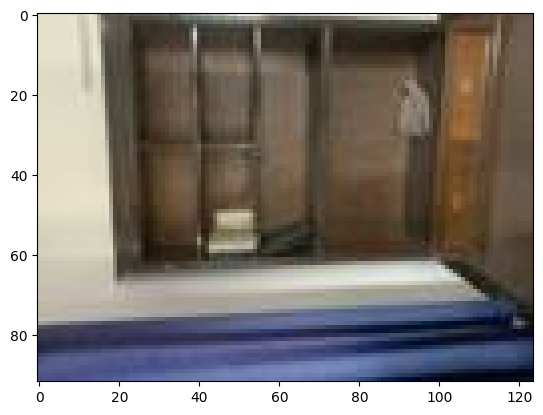

In [3]:
config = ReadConfig(path ='../cfg/nerfacto.yaml')
initial_particles = get_initial_particles(config)
filter = ParticleFilter(initial_particles)
use_convergence_protection = config.get_param('use_convergence_protection')
use_weighted_avg = config.get_param('use_weighted_avg')
number_convergence_particles = config.get_param('number_convergence_particles')
convergence_noise = config.get_param('convergence_noise')
use_received_image = config.get_param('use_received_image')
sampling_strategy = config.get_param('sampling_strategy')
ckpt_dir = config.get_param('ckpt_dir')
data_dir = config.get_param('data_dir')
batch_size = config.get_param('batch_size')
num_particles = config.get_param('num_particles')
px_noise = config.get_param('px_noise')
py_noise = config.get_param('py_noise')
pz_noise = config.get_param('pz_noise')
rot_x_noise = config.get_param('rot_x_noise')
rot_y_noise = config.get_param('rot_y_noise')
rot_z_noise = config.get_param('rot_z_noise')
px_noise: 0.02
py_noise: 0.02
pz_noise: 0.02
rot_x_noise: 0.01
rot_y_noise: 0.04
rot_z_noise: 0.01


nerf_model = load_nerfacto_model(Path(ckpt_dir))
device = nerf_model.device
dataset = SceneDataset(data_dir, device=device, filename='poses_test_15.txt')
metadata = dataset.metadata
subsample_method = 'sift'
subsample_n_points = 100
subsample_dilation = 5
image_sampler = ImageSubsampler(subsample_method, subsample_n_points, subsample_dilation)


eval_index = 0
target = dataset[eval_index]['image']
target_image = target.permute(1, 2, 0)
target_pose = dataset[eval_index]['qctc']
(mask,), (n_points_in_mask,) = image_sampler.get_mask(target[None], True)
mask = torch.tensor(mask)
print(f'Target Pose: {target_pose}')
plt.imshow(target_image.clone().detach().cpu())

In [4]:
def plot_particles(particles, gt):
    fig = plt.figure(figsize=(24,12))
    grid = fig.add_gridspec(nrows=3, ncols=2)

    #! Plot Final Particles
    final_particles = particles.clone().detach().cpu().numpy()

    ax = fig.add_subplot(grid[:2,0], projection='3d')
    ax.view_init(elev=-70, azim=90, roll=0)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

    final_particles = utils.normalize_qt(final_particles) # Normalize q
    cam_orn = (-1,1,-1)

    # Plot Camera Poses on this time step
    plot_cam_poses(final_particles, ax, cam_orientation=cam_orn, scale=0.02, alpha=0.3)
    plot_cam_poses(gt.unsqueeze(0), ax, cam_orientation=cam_orn, scale=0.02, alpha=1, color='green')

    plt.savefig(f'test-{get_timestamp()}.png')
    # plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

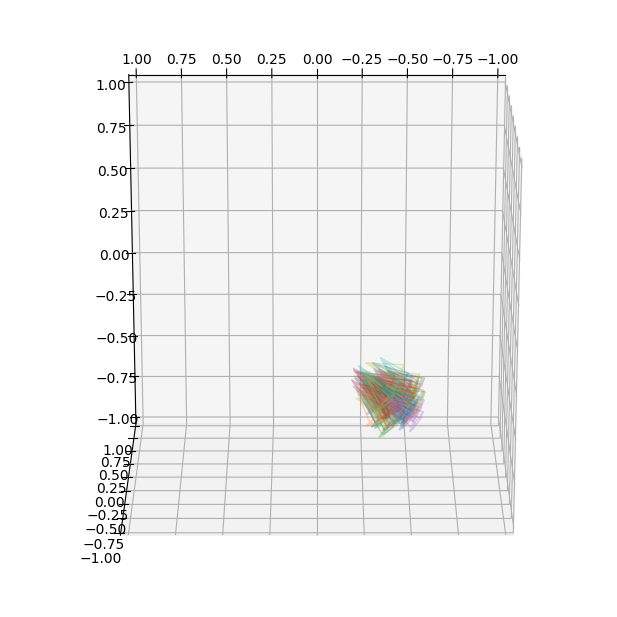

In [6]:
for iteration in tqdm(range(10)):
    start_time = time.time()

    # make copies to prevent mutations
    particles_position_before_update = np.copy(filter.particles['position'])
    particles_rotation_before_update = np.copy(filter.particles['rotation'])

    if use_convergence_protection:
        for i in range(number_convergence_particles):
            t_x = np.random.uniform(low=-convergence_noise, high=convergence_noise)
            t_y = np.random.uniform(low=-convergence_noise, high=convergence_noise)
            t_z = np.random.uniform(low=-convergence_noise, high=convergence_noise)
            # TODO this is not thread safe. have two lines because we need to both update
            # particles to check the loss and the actual locations of the particles
            filter.particles["position"][i] = filter.particles["position"][i] + np.array([t_x, t_y, t_z])
            particles_position_before_update[i] = particles_position_before_update[i] + np.array([t_x, t_y, t_z])
    
    # yprs = np.array([x.ypr() for x in filter.particles['rotation']])
    # quats = np.array([euler_to_quaternion(ypr[0], ypr[1], ypr[2]) for ypr in yprs])
    quats = np.array([ rotmat2qvec(x.matrix()) for x in filter.particles['rotation']])
    # pdb.set_trace()

    particles = np.concatenate((quats, filter.particles['position']), axis=-1)
    particles = torch.tensor(particles)
    with torch.no_grad():
        losses = get_photometric_error_nerfacto(
            particles=particles,
            target_images=target,
            nerf=nerf_model,
            meta=metadata,
            device=device,
            masks=mask,
            no_of_rays=batch_size*num_particles)
        
    # pdb.set_trace()

    for index, particle in enumerate(particles_position_before_update):
            filter.weights[index] = 1/losses[index]

    if use_weighted_avg:
            avg_pose = filter.compute_weighted_position_average()
    else:
        avg_pose = filter.compute_simple_position_average()

    avg_rot = filter.compute_simple_rotation_average()
    avg_rot_ypr = avg_rot.ypr()
    quat = euler_to_quaternion(avg_rot_ypr[0], avg_rot_ypr[1], avg_rot_ypr[2])
    filter.predict_no_motion(px_noise, py_noise, pz_noise, 0, 0, 0)
    # pdb.set_trace()
    if(iteration % 2 == 0):
        plot_particles(particles, target_pose.to('cpu'))
        print(f'{iteration}. {list(quat) + list(avg_pose)} {time.time()-start_time}')
print(target_pose)
print(type(particles))

In [ ]:
particles.device

In [ ]:
particles.shape

In [ ]:
target_pose.unsqueeze(0)

In [ ]:
target_pose.unsqueeze(0).shape


In [ ]:
from nerfacto_navigator import NerfactoNavigator

In [ ]:
navigator = NerfactoNavigator('../cfg/nerfacto.yaml')
for i in range(100):
    pose_estimate = navigator.rgb_run()
    print(pose_estimate)
print(navigator.target_pose)